In [1]:
import pandas as pd
from typing import List, Union
from tqdm import tqdm
from crypto_momentum_portfolios.data_loader import CryptoDataLoader
from crypto_momentum_portfolios.utils import get_rebalance_dates

dl = CryptoDataLoader()
dl.assets

['bitcoin',
 'ethereum',
 'bitcoin_cash',
 'ripple',
 'litecoin',
 'tron',
 'ethereum_classic',
 'chainlink',
 'stellar',
 'cardano',
 'dash',
 'tezos',
 'binancecoin',
 'solana',
 'matic_network',
 'dogecoin',
 'avalanche_2']

In [2]:
univers = dl.get_crypto(
    "all",
    data_frequency="daily",
    fields=["price", "returns", "momentum"],
    flatten_fields_with_crypto=False,
    momentum_lookback=10,
)
univers

price                                                  \
                 bitcoin     ethereum bitcoin_cash    ripple    litecoin   
date                                                                       
2021-01-01  29022.418395   738.616938   343.519521  0.220535  124.798698   
2021-01-02  29352.126792   730.147340   341.244838  0.237437  125.981371   
2021-01-03  32163.824935   777.696065   354.811623  0.221870  137.703259   
2021-01-04  33008.226203   967.000597   419.500965  0.225637  159.495436   
2021-01-05  31515.575967  1025.654768   397.451721  0.234618  152.068323   
...                  ...          ...          ...       ...         ...   
2023-06-25  30537.816665  1875.059962   213.911795  0.486697   89.534943   
2023-06-26  30454.756974  1899.147312   197.212402  0.489572   88.209262   
2023-06-27  30285.505064  1859.802420   224.741832  0.479150   87.242862   
2023-06-28  30693.546356  1890.012904   230.006452  0.484370   87.971243   
2023-06-29  30083.477245  1828.458336   225.560881  0.464818   83.090666   

                                                                      ...  \
                tron ethereum_classic  chainlink   stellar   cardano  ...   
date                                                                  ...   
2021-01-01  0.026840         5.672940  11.253218  0.128612  0.182071  ...   
2021-01-02  0.026946         5.698495  11.855183  0.132343  0.175679  ...   
2021-01-03  0.027300         5.790775  12.215407  0.128446  0.178185  ...   
2021-01-04  0.029769         6.630844  13.649759  0.135968  0.205037  ...   
2021-01-05  0.030560         6.855047  13.312714  0.163227  0.218888  ...   
...              ...              ...        ...       ...       ...  ...   
2023-06-25  0.072188        19.174019   6.142787  0.090576  0.289614  ...   
2023-06-26  0.073170        18.359780   6.147151  0.091688  0.292018  ...   
2023-06-27  0.073799        18.635569   6.068575  0.092131  0.280616  ...   
2023-06-28  0.074339        18.687736   6.202058  0.102066  0.286364  ...   
2023-06-29  0.073752        17.494117   5.816176  0.100513  0.266987  ...   

            momentum                                                      \
           chainlink   stellar   cardano      dash     tezos binancecoin   
date                                                                       
2021-01-01  1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
2021-01-02  1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
2021-01-03  1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
2021-01-04  1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
2021-01-05  1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
...              ...       ...       ...       ...       ...         ...   
2023-06-25  1.158807  1.184424  1.106662  1.187244  1.144809    1.001734   
2023-06-26  1.156414  1.182639  1.108869  1.156699  1.145291    0.998759   
2023-06-27  1.149910  1.156437  1.051136  1.164697  1.093061    0.966222   
2023-06-28  1.202373  1.282501  1.096647  1.195509  1.123517    0.973335   
2023-06-29  1.137080  1.257046  1.015026  1.097928  1.049012    0.949565   

                                                          
              solana matic_network  dogecoin avalanche_2  
date                                                      
2021-01-01  1.000000      1.000000  1.000000    1.000000  
2021-01-02  1.000000      1.000000  1.000000    1.000000  
2021-01-03  1.000000      1.000000  1.000000    1.000000  
2021-01-04  1.000000      1.000000  1.000000    1.000000  
2021-01-05  1.000000      1.000000  1.000000    1.000000  
...              ...           ...       ...         ...  
2023-06-25  1.128129      1.110502  1.082668    1.142426  
2023-06-26  1.108095      1.130937  1.072274    1.164603  
2023-06-27  1.042086      1.051345  1.040251    1.132755  
2023-06-28  1.075779      1.114809  1.051344    1.165237  
2023-06-29  0.997360      1.001536  1.00295

In [3]:
from typing import Dict


def rank_by_field(univers: Union[pd.DataFrame, pd.Series], field: str):
    return univers[f"{field}"].iloc[-1].sort_values(ascending=False).index.to_list()


def rank_by_field_for_rows(row: Union[pd.DataFrame, pd.Series], field: str):
    return row[f"{field}"].sort_values(ascending=False).index.to_list()


def equaly_weighted_assets(selected_assets: list) -> Dict[str, float]:
    return {asset: 1 / len(selected_assets) for asset in selected_assets}

In [8]:
univers.loc["2021-01-01", "returns"]

bitcoin             0.0
ethereum            0.0
bitcoin_cash        0.0
ripple              0.0
litecoin            0.0
tron                0.0
ethereum_classic    0.0
chainlink           0.0
stellar             0.0
cardano             0.0
dash                0.0
tezos               0.0
binancecoin         0.0
solana              0.0
matic_network       0.0
dogecoin            0.0
avalanche_2         0.0
Name: 2021-01-01 00:00:00, dtype: float64

Day 1, stock 1 has 2% and stock 2 has 3% return. The weights day 2 is then: Stock 1: $\frac{0.5 \times 1.02}{0.5\times1.02+0.5 \times 1.03} = 0.4975$ Stock 2: $\frac{0.5 \times 1.03}{0.5 \times 1.02+0.5 \times 1.03} = 0.5025$

Next day: stock 1 has 1% and stock 2 has 2% return Stock 1: $\frac{0.4975 \times 1.01}{0.4975 \times 1.01+0.5025 \times 1.02}$


$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


In [44]:
# pre assign memory for speed
import numpy as np


returns_histo, weights_histo = (
    [] * univers.shape[0],
    [] * univers.shape[0],
)
REBALANCE_DATES = get_rebalance_dates(
    univers.index[0], univers.index[-1], "month_start"
)

TRANSACTION_COST = 0.001
SLIPPAGE_EFFECT = 0.001

for index, row in tqdm(
    univers.loc["2021-02-01":].iterrows(),
    desc="Backtesting the strategy",
    total=len(univers),
    leave=False,
):
    if index in REBALANCE_DATES:
        print(f"Rebalancing the portfolio on {index}...")
        securities = rank_by_field_for_rows(row, "momentum")[:5]
        weights = equaly_weighted_assets(securities)

    weights_histo.append(weights)
    returns = univers.loc[index, "returns"][securities].to_numpy()
    returns_plus_1 = returns + 1
    weights_np = np.array(list(weights.values()))
    returns_histo.append(returns @ weights_np)
    new_weights = {sec:unit_weight for sec, unit_weight in zip(securities ,(weights_np * returns_plus_1) / (
        returns_plus_1 @ np.array(weights_np)
    ))}
    weights = new_weights

Backtesting the strategy:   3%|▎         | 31/910 [00:00<00:03, 222.47it/s]

Rebalancing the portfolio on 2021-02-01 00:00:00...
Rebalancing the portfolio on 2021-03-01 00:00:00...


Backtesting the strategy:   6%|▋         | 58/910 [00:00<00:03, 246.49it/s]

Rebalancing the portfolio on 2021-04-01 00:00:00...


Backtesting the strategy:  12%|█▏        | 108/910 [00:00<00:04, 170.00it/s]

Rebalancing the portfolio on 2021-05-01 00:00:00...
Rebalancing the portfolio on 2021-06-01 00:00:00...


Backtesting the strategy:  19%|█▉        | 175/910 [00:00<00:03, 192.48it/s]

Rebalancing the portfolio on 2021-07-01 00:00:00...
Rebalancing the portfolio on 2021-08-01 00:00:00...


Backtesting the strategy:  26%|██▋       | 239/910 [00:01<00:03, 173.03it/s]

Rebalancing the portfolio on 2021-09-01 00:00:00...
Rebalancing the portfolio on 2021-10-01 00:00:00...


Backtesting the strategy:  32%|███▏      | 295/910 [00:01<00:03, 157.77it/s]

Rebalancing the portfolio on 2021-11-01 00:00:00...
Rebalancing the portfolio on 2021-12-01 00:00:00...


Backtesting the strategy:  40%|████      | 366/910 [00:02<00:02, 209.64it/s]

Rebalancing the portfolio on 2022-01-01 00:00:00...
Rebalancing the portfolio on 2022-02-01 00:00:00...


Backtesting the strategy:  45%|████▌     | 411/910 [00:02<00:03, 157.59it/s]

Rebalancing the portfolio on 2022-03-01 00:00:00...


Backtesting the strategy:  47%|████▋     | 430/910 [00:02<00:02, 162.18it/s]

Rebalancing the portfolio on 2022-04-01 00:00:00...


Backtesting the strategy:  51%|█████     | 463/910 [00:02<00:03, 122.64it/s]

Rebalancing the portfolio on 2022-05-01 00:00:00...


Backtesting the strategy:  58%|█████▊    | 531/910 [00:03<00:02, 160.01it/s]

Rebalancing the portfolio on 2022-06-01 00:00:00...
Rebalancing the portfolio on 2022-07-01 00:00:00...


Backtesting the strategy:  63%|██████▎   | 572/910 [00:03<00:02, 166.57it/s]

Rebalancing the portfolio on 2022-08-01 00:00:00...
Rebalancing the portfolio on 2022-09-01 00:00:00...


Backtesting the strategy:  69%|██████▉   | 628/910 [00:03<00:01, 164.31it/s]

Rebalancing the portfolio on 2022-10-01 00:00:00...


Backtesting the strategy:  71%|███████   | 646/910 [00:04<00:01, 163.46it/s]

Rebalancing the portfolio on 2022-11-01 00:00:00...


Backtesting the strategy:  78%|███████▊  | 708/910 [00:04<00:01, 180.37it/s]

Rebalancing the portfolio on 2022-12-01 00:00:00...
Rebalancing the portfolio on 2023-01-01 00:00:00...


Backtesting the strategy:  82%|████████▏ | 746/910 [00:04<00:01, 162.06it/s]

Rebalancing the portfolio on 2023-02-01 00:00:00...
Rebalancing the portfolio on 2023-03-01 00:00:00...


Backtesting the strategy:  89%|████████▊ | 806/910 [00:04<00:00, 182.09it/s]

Rebalancing the portfolio on 2023-04-01 00:00:00...
Rebalancing the portfolio on 2023-05-01 00:00:00...


Backtesting the strategy:  95%|█████████▍| 860/910 [00:05<00:00, 154.15it/s]

Rebalancing the portfolio on 2023-06-01 00:00:00...


<Axes: xlabel='date'>

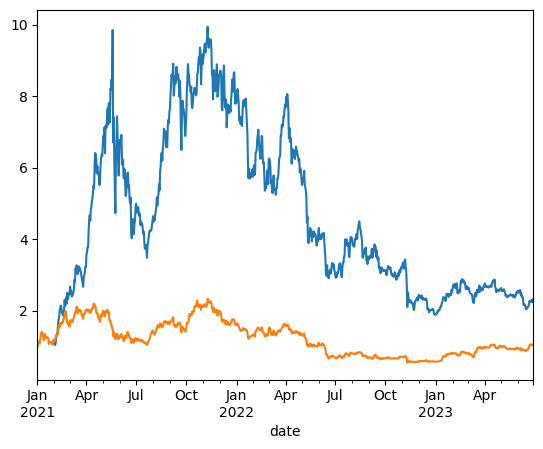

In [45]:

(1+ pd.Series(returns_histo,index=univers.loc["2021-02-01":].index)).cumprod().plot()
(1+ univers["returns"]['bitcoin']).cumprod().plot()


In [46]:
weights_histo

[{'dogecoin': 0.2,
  'ripple': 0.2,
  'solana': 0.2,
  'matic_network': 0.2,
  'stellar': 0.2},
 {'dogecoin': 0.24734809998523108,
  'ripple': 0.21187676257121155,
  'solana': 0.1870142370935604,
  'matic_network': 0.17852080245319613,
  'stellar': 0.17524009789680087},
 {'dogecoin': 0.2342809312486551,
  'ripple': 0.1660766605709897,
  'solana': 0.20964595750681472,
  'matic_network': 0.19820659202117,
  'stellar': 0.19178985865237053},
 {'dogecoin': 0.20991273502518412,
  'ripple': 0.16223860743019852,
  'solana': 0.23507378647773974,
  'matic_network': 0.1955099986822977,
  'stellar': 0.19726487238457988},
 {'dogecoin': 0.2281131750493216,
  'ripple': 0.15950576308158307,
  'solana': 0.23520025309033363,
  'matic_network': 0.1927315607509257,
  'stellar': 0.184449248027836},
 {'dogecoin': 0.28593921954738843,
  'ripple': 0.15612936389537774,
  'solana': 0.2276579078930978,
  'matic_network': 0.17861254533662776,
  'stellar': 0.15166096332750834},
 {'dogecoin': 0.24424245642524298,
 